<a href="https://colab.research.google.com/github/Satwikram/NLP-Implementations/blob/main/BERT/BERT%20Word%20Embeddings%20%2B%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

### Connecting to Kaggle

In [23]:
from google.colab import files

files.upload()


! mkdir ~/.kaggle


! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


### Downloading dataset

In [ ]:
!kaggle competitions download -c sentiment-analysis-on-movie-reviews

In [25]:
y!unzip /content/train.tsv.zip
!unzip /content/test.tsv.zip

Archive:  /content/train.tsv.zip
replace train.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.tsv               
Archive:  /content/test.tsv.zip
replace test.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.tsv                


In [ ]:
!pip install transformers

### Importing Dependencies

In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFAutoModel
import os
from datetime import datetime
from pathlib import Path

from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, BatchNormalization, Input, Dropout
from tensorflow.keras.models import Model, load_model

In [28]:
dataset = pd.read_csv("/content/train.tsv", sep = "\t")

In [29]:
dataset.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


### Data labels

The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

In [30]:
dataset = dataset.drop_duplicates(subset=['SentenceId'], keep='first')

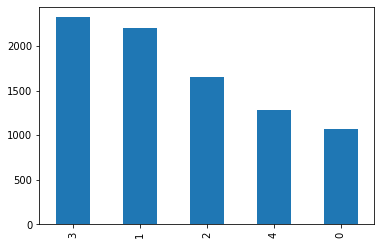

In [31]:
dataset["Sentiment"].value_counts().plot(kind = "bar")

### Preparing inputs and outputs

In [32]:
sequence_length = 512
num_samples = len(dataset)

num_samples, sequence_length

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


tokens = tokenizer(dataset["Phrase"].tolist(), max_length = sequence_length, 
                   truncation = True, padding = "max_length", add_special_tokens = True,
                   return_tensors = "np")

arr = dataset["Sentiment"].values

labels = np.zeros((num_samples, arr.max()+1))

labels[np.arange(num_samples), arr] = 1

### Creating Dataset

In [33]:
Xids = tokens["input_ids"]
Xmasks = tokens["attention_mask"]

dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmasks, labels))

def map_fun(input_ids, masks, labels):

  return {"input_ids": input_ids,
          "attention_mask": masks}, labels

dataset = dataset.map(map_fun)

batch_size = 32

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder = True)

split = 0.9
size = int((Xids.shape[0] / batch_size)*split)

train_ds = dataset.take(size)
val_ds = dataset.skip(size)

### Building BERT Model

In [34]:
bert = TFAutoModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [35]:
input_ids = tf.keras.layers.Input(shape = (512,), name = "input_ids",
                                  dtype = "int32")

mask = tf.keras.layers.Input(shape = (512,), name = "attention_mask",
                                  dtype = "int32")

embeddings = bert(input_ids, attention_mask = mask)[0]
                                    
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences = True))(embeddings)
x = tf.keras.layers.BatchNormalization()(x)
                
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))(x)
x = tf.keras.layers.BatchNormalization()(x)

y = tf.keras.layers.Dense(5, activation = "softmax", name = "outputs")(x)

model = tf.keras.Model(inputs = [input_ids, mask], outputs = y)

In [36]:
model.layers[2].trainable = False

In [37]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

In [38]:
optimizer = tf.keras.optimizers.Adam(lr = 5e-5, decay = 1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [39]:
model.compile(optimizer = optimizer, loss = loss, metrics = [acc])

### Callbacks

In [40]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("models/model.hdf5", monitor = "val_loss", save_best_only = True, 
                                                verbose = 1)

earlystopping = tf.keras.callbacks.EarlyStopping( monitor = "val_loss", verbose = 1, restore_best_weights = True,
                                                 patience = 2)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.2,
                              patience = 1, min_lr = 0.001, verbose = 1)

callbacks = [checkpoint, earlystopping, reduce_lr]

In [ ]:
history = model.fit(train_ds, validation_data =  val_ds, epochs = 3, callbacks = callbacks)

Epoch 1/3
 49/239 [=====>........................] - ETA: 11:15 - loss: 1.8316 - accuracy: 0.3278